In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn

In [377]:
#Define classes from nn.Module (easy to work with when taking gradients).Note that in the simplest case of Woodford
# encoder and decoder are not strictly necessary, as they are both determined by the same parameters.
class CategoricalEncoder(torch.nn.Module):
    def __init__(self,mu0,sigma0,q0):
        super().__init__()
        self.a = torch.nn.Parameter(-1/(2*sigma0**2))
        self.b = torch.nn.Parameter(mu0/sigma0**2)
        self.c = torch.nn.Parameter(-mu0**2/(2*sigma0**2) -torch.log(sigma0) - torch.log(F.softmax(q0)))
    def forward(self,x):
        # x has shape [batch_dim,x_dim], a,b,c has shape [x_dim, N]
        p_tilde = (x**2)@(self.a) + x@(self.b) + self.c
        return F.softmax(p_tilde,dim=1)

class GaussianDecoder(torch.nn.Module):
    def __init__(self,mu0,sigma0,q0):
        super().__init__()
        self.q  = torch.nn.Parameter(F.softmax(q0))
        self.mu = torch.nn.Parameter(mu0.transpose(0,1))
        self.sigma = torch.nn.Parameter(sigma0.transpose(0,1))
    def forward(self,r):
        return (r)@(self.mu),(r)@(self.sigma)








In [378]:
 def rec_loss(x_data,encoder,decoder):
    #Compute p(j|x) as a bs x N matrix
    p_j_x = encoder(x_data)
    #Compute log(q(x|j))
    inv_sigma2 = 1/(decoder.sigma.transpose(0,1))**2
    mp = (decoder.mu.transpose(0,1)*inv_sigma2)
    logq_x_j = -0.5*(x_data**2)@inv_sigma2 + (x_data@mp) - 0.5*(mp)*(decoder.mu.transpose(0,1)) -torch.log  (decoder.sigma.transpose(0,1))
    # E_x[ sum_j p(j|x)*log(q(x|j))]
    loss = ((p_j_x*logq_x_j).sum(dim=1)).mean()
    return loss
def Dkl(x_data,encoder,decoder):
    p_j_x = encoder(x_data)
    dkl = (p_j_x*torch.log(p_j_x /F.softmax(decoder.q))).sum(dim=1).mean()
    return dkl

In [461]:
N = 20
mu0 = torch.arange(0,10,10/N)[None,:]
sigma0 = torch.ones(N)[None,:]
q0 = 1/N*torch.ones(N)[None,:]



In [468]:
#Define data distribution
x_data = torch.distributions.exponential.Exponential(0.1).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
encoder = CategoricalEncoder(mu0,sigma0,q0)
decoder = GaussianDecoder(mu0,sigma0,q0)
#Define optimizer and parameters to iterate on
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.SGD(params,0.001)

<ipython-input-377-8c7188e2c3d3>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.c = torch.nn.Parameter(-mu0**2/(2*sigma0**2) -torch.log(sigma0) - torch.log(F.softmax(q0)))
<ipython-input-377-8c7188e2c3d3>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))


In [469]:
#for i in range(1,5):
loss = rec_loss(x_data,encoder,decoder) + Dkl(x_data,encoder,decoder)
optimizer.zero_grad()
loss.backward()
optimizer.step()

<ipython-input-378-db197926d368>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = (p_j_x*torch.log(p_j_x /F.softmax(decoder.q))).sum(dim=1).mean()


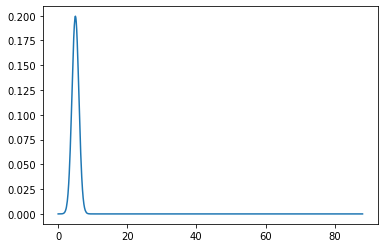

In [464]:
with torch.no_grad():
    plt.plot(x_sorted,encoder(x_sorted)[:,10])

In [476]:
list(encoder.parameters())

[Parameter containing:
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        requires_grad=True),
 Parameter containing:
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        requires_grad=True),
 Parameter containing:
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        requires_grad=True)]